# Structural Health Monitoring: Damage Detection under Environmental Variability

This notebook demonstrates a data-driven approach to **Structural Health Monitoring (SHM)**. 
We will simulate a structural system that is subject to:
1.  **Operational Variability:** Random excitation.
2.  **Environmental Variability:** Temperature changes that affect material stiffness.
3.  **Structural Damage:** A loss of stiffness in one of the components.

**Goal:** To detect the damage despite the masking effect of temperature changes, using **Principal Component Analysis (PCA)** and **Mahalanobis Distance**.

---
**Table of Contents:**
1.  [The Physical System](#1.-The-Physical-System)
2.  [Simulating System Response](#2.-Simulating-System-Response-(PSD))
3.  [The Environmental Effect](#3.-The-Environmental-Effect-(Temperature))
4.  [Visualizing the Problem](#3.-Visualizing-the-Effect-of-Temperature)
5.  [PCA for Environmental Compensation](#5.-PCA-for-Environmental-Compensation)
6.  [Simulating Damage](#6.-Simulating-Damage)
7.  [Damage Detection](#7.-Damage-Detection-using-PCA)
8.  [Automated Alarm System](#9.-Automated-Alarm-System-(Mahalanobis-Distance))


## 1. The Physical System
We consider a chain of 3 masses connected by springs.  No damping is considered for simplicity. 
The following schematic illustrates the system: 

![System Schematic](figures/system_schematic.png)

### System Parameters
- Masses: m1 = 1 kg , m2 = 2 kg , m3 = 3 kg
- Spring Stiffness: k1 = 1000 N/m, k2 = 1500 N/m, k3 = 500 N/m at reference temperature (0°C)
- Temperature Effect: Stiffness decreases by 0.5% per °C increase 
To be able to simulate the system we will need to define its equations of motion. $$ M \ddot{u}(t) + K u(t) = F(t)$$ where:
- \( M \) is the mass matrix
- \( K \) is the stiffness matrix
- \( u(t) \) is the displacement vector
- \( F(t) \) is the external force vector

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# --- System Parameters ---
m1 = 1.0  # Mass 1 (kg)
m2 = 2.0  # Mass 2 (kg)
m3 = 3.0  # Mass 3 (kg)
k1 = 1000.0  # Base Stiffness (N/m) at T=0  
k2 = 1500.0  # Stiffness of spring 2 (N/m) at T=0
k3 = 500.0   # Stiffness of spring 3 (N/m

# Mass Matrix (Lumped mass)
# --- let's define the function that we will use to create the mass matrix  and stiffness matrix ---
def get_mass_matrix(m1, m2, m3):
    """
    Constructs the mass matrix for a 3DOF chain system.
    """
    M = np.diag([m1, m2, m3])
    return M

def get_stiffness_matrix(k1, k2, k3):
    """
    Constructs the stiffness matrix for a 3DOF chain system.
    Ground - k1 - m1 - k2 - m2 - k3 - m3
    """
    K = np.array([
        [k1 + k2, -k2, 0],
        [-k2, k2 + k3, -k3],
        [0, -k3, k3]
    ])
    return K

# Solve Eigenvalue Problem for Natural Frequencies and Mode Shapes 
# this is similair to 1 dof case where w = sqrt(k/m) however here we have multiple dofs

def solve_eigenfrequencies(K, M):
    """
    Solves the generalized eigenvalue problem K * phi = w^2 * M * phi
    Returns natural frequencies in Hz.
    """
    evals, evecs = eigh(K, M)
    frequencies = np.sqrt(evals) / (2 * np.pi)
    return frequencies 
M = get_mass_matrix(m1, m2, m3)
K = get_stiffness_matrix(k1, k2, k3)
print("System defined.") 
print("Mass Matrix M:\n", M)
print("Base Stiffness Matrix K at T=0:\n", K)
print("let's solve the eigenvalue problem to get natural frequencies")
frequencies = solve_eigenfrequencies(K, M)
print(f"Natural Frequencies (Hz):{frequencies}")


System defined.
Mass Matrix M:
 [[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 3.]]
Base Stiffness Matrix K at T=0:
 [[ 2500. -1500.     0.]
 [-1500.  2000.  -500.]
 [    0.  -500.   500.]]
let's solve the eigenvalue problem to get natural frequencies
Natural Frequencies (Hz):[1.3879648  3.69332236 8.79264894]


In [ ]:
# --- Define Damping ---
# Rayleigh Damping: C = alpha*M + beta*K
# We choose coefficients to give small damping (e.g., ~1%)
alpha = 0.5
beta = 0.0001
C = alpha * M + beta * K

# --- State Space Model ---
# State vector x = [u; u_dot]
n_dof = 3
Minv = np.linalg.inv(M)

# System Matrix A
# [ 0      I ]
# [-M^-1*K -M^-1*C]
A_top = np.hstack([np.zeros((n_dof, n_dof)), np.eye(n_dof)])
A_bot = np.hstack([-Minv @ K, -Minv @ C])
A_ss = np.vstack([A_top, A_bot])

# Input Matrix B
# Force applied to Mass 1 (x1)
# F = [f(t), 0, 0].T
B_force = np.array([[1], [0], [0]]) # Force location vector
B_ss = np.vstack([np.zeros((n_dof, 1)), Minv @ B_force])

# Output Matrix C
# Measuring Displacement of Mass 3 (x3)
# y = [0, 0, 1, 0, 0, 0] * x
C_ss = np.zeros((1, 2*n_dof))
C_ss[0, 2] = 1 # Index 2 corresponds to u3

D_ss = np.zeros((1, 1))

# Create System
sys = signal.StateSpace(A_ss, B_ss, C_ss, D_ss)

# --- Simulation ---
fs = 100 # Sampling frequency (Hz)
T_sim = 60 # Duration (seconds)
t_sim = np.arange(0, T_sim, 1/fs)

# Generate White Noise Input
np.random.seed(10)
u_input = np.random.normal(0, 10, len(t_sim)) # Mean 0, Std 10 N

# Simulate Response
t, y, x_state = signal.lsim(sys, u_input, t_sim)
y_out = y.flatten() # Displacement of Mass 3

# --- Plotting ---
plt.figure(figsize=(12, 8))

# 1. Time History
plt.subplot(2, 1, 1)
plt.plot(t, y_out, 'b', linewidth=1)
plt.title("System Response (Displacement of Mass 3) to White Noise")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.grid(True, alpha=0.3)
plt.xlim(0, 10) # Zoom in on first 10 seconds

# 2. Power Spectral Density (PSD)
f, Pxx = signal.welch(y_out, fs, nperseg=1024)

plt.subplot(2, 1, 2)
plt.semilogy(f, Pxx, 'r')
plt.title("Power Spectral Density (PSD) of Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (m^2/Hz)")
plt.grid(True, alpha=0.3, which='both')
plt.xlim(0, 15) # Focus on relevant frequency range

# Overlay theoretical frequencies
for freq in frequencies:
    plt.axvline(x=freq, color='k', linestyle='--', alpha=0.5)
    plt.text(freq, np.max(Pxx)/10, f" {freq:.2f} Hz", rotation=90)

plt.tight_layout()
plt.show()

## 2. Simulating System Response (PSD)
To understand how we can identify these frequencies from data, let's simulate the system's response to a random excitation (White Noise).

- **Excitation:** White noise force applied to Mass 1 ($F_1$).
- **Measurement:** Displacement of Mass 3 ($u_3$).
- **Damping:** We add a small amount of damping (Rayleigh damping) to make the simulation realistic.

## The effect of temperature on the system stiffness
We will define the stiffness of each spring as a function of temperature \( T \): 
\[] k_i(T) = k_i(0) \cdot (1 - \alpha_i T) \)
where:
- \( k_i(0) \) is the stiffness at reference temperature (0°C)
- \( \alpha_i \) is the temperature coefficient for spring i
- \( T \) is the temperature in °C

In order to have a monitoring setup we will vary the temperature cyclically between 0°C and 30°C over the simulation period.


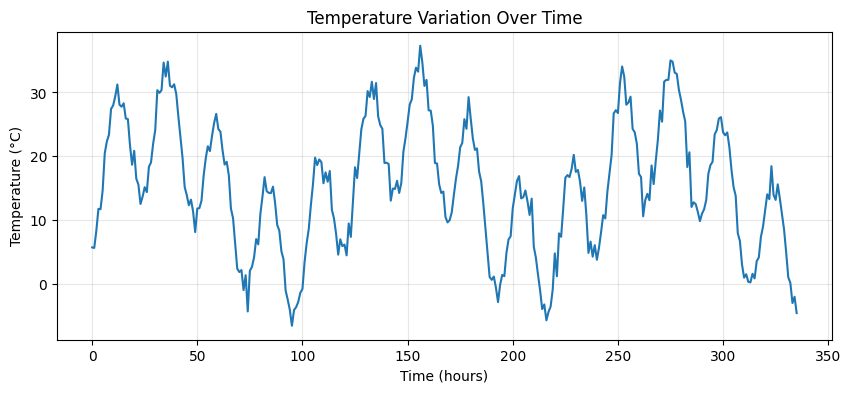

In [131]:
# System parameters 
alpha1 = 0.0005  # Temperature coefficient for spring 1
alpha2 = -0.01 # Temperature coefficient for spring 2
alpha3 = -0.1 # Temperature coefficient for spring 3

# vector of time: 2 weeks of monitoring at 1 sample per hour
time = np.arange(0, 14*24, 1)  # hours

np.random.seed(42)  # for reproducibility
temperature = 15 + 10 * np.sin(2 * np.pi * time / 24 - np.pi/2) + 10 * np.sin(2 * np.pi * time / (5*24))  + np.random.normal(0, 1.5, len(time))

# let's plot the temperature variation
plt.figure(figsize=(10,4))
plt.plot(time, temperature)
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Variation Over Time")
plt.grid(True, alpha=0.3)
plt.show()

## 2. Simulating the Monitoring Campaign (Healthy & Damaged States)

We will now simulate the monitoring campaign over the 2-week period.
- **Phase 1 (Healthy):** The system operates normally for the first 250 hours.
- **Phase 2 (Damaged):** At t=250 hours, a damage event occurs (stiffness reduction in Spring 3).

We will define a function to update the stiffness matrix based on both **Temperature** and **Damage**.

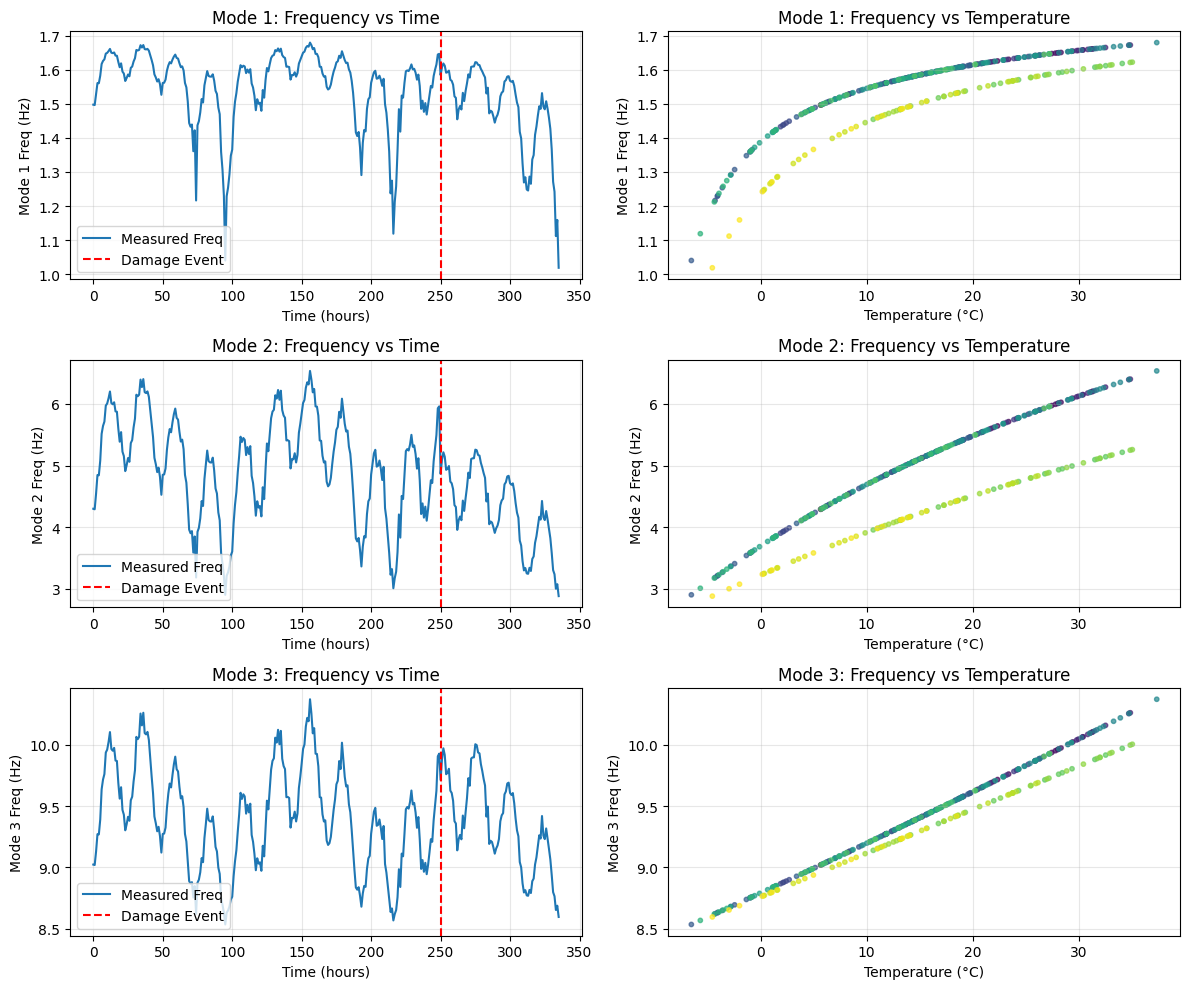

In [132]:
def get_current_stiffness_matrix(T, k1, k2, k3, alpha1, alpha2, alpha3, damage_level=0.0):
    """
    Updates the stiffness matrix based on temperature T and damage level.
    damage_level: fraction of stiffness reduction in spring 3 (0 to 1)
    """
    # Apply temperature effect
    k1_T = k1 * (1 - alpha1 * T)
    k2_T = k2 * (1 - alpha2 * T) 
    # Apply temperature AND damage effect to Spring 3
    k3_T = k3 * (1 - alpha3 * T) * (1 - damage_level)  
    
    K_T = get_stiffness_matrix(k1_T, k2_T, k3_T)
    return K_T

# --- Simulation ---
damage_start_time = 250 # hours
damage_severity = 0.4  # 40% damage in spring 3

measured_frequencies = []

for idx, T in enumerate(temperature):
    current_time = time[idx]
    
    if current_time < damage_start_time:
        # Healthy State
        K_T = get_current_stiffness_matrix(T, k1, k2, k3, alpha1, alpha2, alpha3, damage_level=0.0)
    else:
        # Damaged State
        K_T = get_current_stiffness_matrix(T, k1, k2, k3, alpha1, alpha2, alpha3, damage_level=damage_severity)
        
    freqs = solve_eigenfrequencies(K_T, M)
    measured_frequencies.append(freqs) 

measured_frequencies = np.array(measured_frequencies)

# --- Plotting ---
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i in range(3):
    # Time History
    axs[i,0].plot(time, measured_frequencies[:,i], label='Measured Freq')
    axs[i,0].axvline(x=damage_start_time, color='r', linestyle='--', label='Damage Event')
    axs[i,0].set_xlabel("Time (hours)")
    axs[i,0].set_ylabel(f"Mode {i+1} Freq (Hz)")
    axs[i,0].set_title(f"Mode {i+1}: Frequency vs Time")
    axs[i,0].grid(True, alpha=0.3)
    axs[i,0].legend(loc='lower left')

    # Temperature Dependency
    # Color points by time to show evolution
    sc = axs[i,1].scatter(temperature, measured_frequencies[:,i], c=time, cmap='viridis', s=10, alpha=0.7)
    axs[i,1].set_xlabel("Temperature (°C)")
    axs[i,1].set_ylabel(f"Mode {i+1} Freq (Hz)")
    axs[i,1].set_title(f"Mode {i+1}: Frequency vs Temperature")
    axs[i,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Damage Detection Strategy 1: Regression Analysis (SVR)

**The Challenge:**
Looking at the plots above (left column), the damage (red dashed line) causes a small drop in frequency. However, this drop is small compared to the fluctuations caused by temperature.
- If we just set a threshold on frequency, we might get false alarms on hot days.
- Or we might miss the damage on cold days.

**The Solution:**
We can model the relationship between **Temperature** and **Frequency** using a regression model (e.g., Support Vector Regression).
1.  **Train** the model on the "Healthy" period (first 250 hours).
2.  **Predict** the expected frequency for the entire duration based on temperature.
3.  **Calculate Residuals** (Actual - Predicted). Large residuals indicate damage.

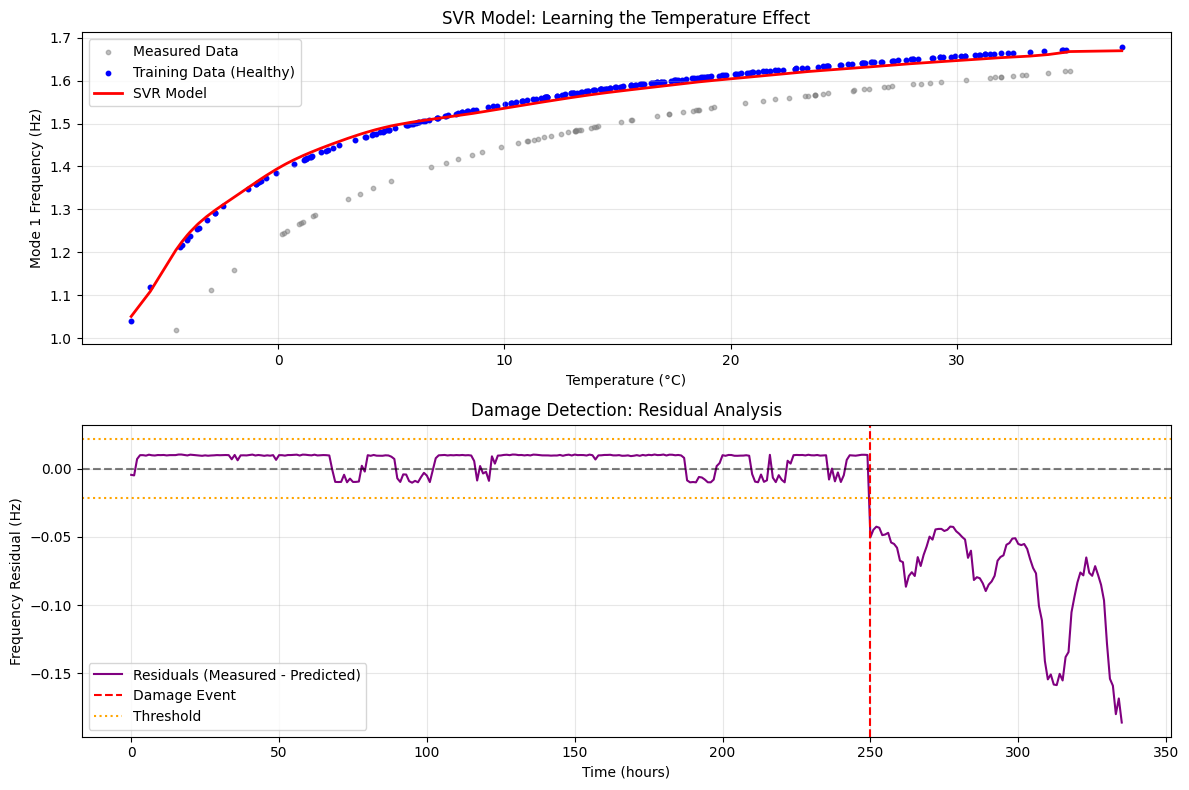

In [ ]:
from sklearn.svm import SVR

# 1. Training Data (Healthy Period only)
train_mask = time < damage_start_time
X_train = temperature[train_mask].reshape(-1, 1)
y_train = measured_frequencies[train_mask, 0] # Modeling Mode 1

# 2. Train SVR Model
# RBF kernel is good for non-linear relationships 
# SVR stands for Support Vector Regression and works with the pri
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svr_model.fit(X_train, y_train)

# 3. Predict for the whole duration
X_all = temperature.reshape(-1, 1)
y_pred = svr_model.predict(X_all)

# 4. Plot Results
plt.figure(figsize=(12, 8))

# Subplot 1: Model Fit
plt.subplot(2, 1, 1)
plt.scatter(temperature, measured_frequencies[:,0], s=10, alpha=0.5, label='Measured Data', c='gray')
plt.scatter(temperature[train_mask], y_train, s=10, color='blue', label='Training Data (Healthy)')
# Sort for clean line plot
sort_idx = np.argsort(temperature)
plt.plot(temperature[sort_idx], y_pred[sort_idx], color='red', linewidth=2, label='SVR Model')
plt.xlabel("Temperature (°C)")
plt.ylabel("Mode 1 Frequency (Hz)")
plt.title("SVR Model: Learning the Temperature Effect")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals (Damage Indicator)
residuals = measured_frequencies[:,0] - y_pred

plt.subplot(2, 1, 2)
plt.plot(time, residuals, label='Residuals (Measured - Predicted)', color='purple')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axvline(x=damage_start_time, color='r', linestyle='--', label='Damage Event')

# Add a simple threshold (e.g., 3 std dev of healthy residuals)
healthy_residuals = residuals[train_mask]
threshold = 3 * np.std(healthy_residuals)
plt.axhline(y=-threshold, color='orange', linestyle=':', label='Threshold')
plt.axhline(y=threshold, color='orange', linestyle=':')

plt.xlabel("Time (hours)")
plt.ylabel("Frequency Residual (Hz)")
plt.title("Damage Detection: Residual Analysis")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Damage Detection Strategy 2: Principal Component Analysis (PCA)

**The Concept:**
Instead of modeling each frequency separately against temperature (like SVR), we can look at the **correlation structure** of all frequencies together.
- **PC1 (Principal Component 1):** Usually captures the dominant trend in the data. In our case, this is the **Temperature Effect**.
- **PC2, PC3... (Residuals):** Capture variations that do not follow the main trend. **Damage** often changes the correlation structure, making it visible in these lower components.

**Steps:**
1.  **Standardize** the data (zero mean, unit variance).
2.  **Train PCA** on the "Healthy" period.
3.  **Project** all data onto the Principal Components.
4.  **Visualize** PC1 vs PC2. We expect the "Damaged" data to deviate from the "Healthy" cluster in the PC2 direction.

In [ ]:
# first 

Explained Variance Ratio: [9.60292366e-01 3.91515047e-02 5.56129089e-04]
PC1 explains 96.0% of the variance (Temperature Effect).


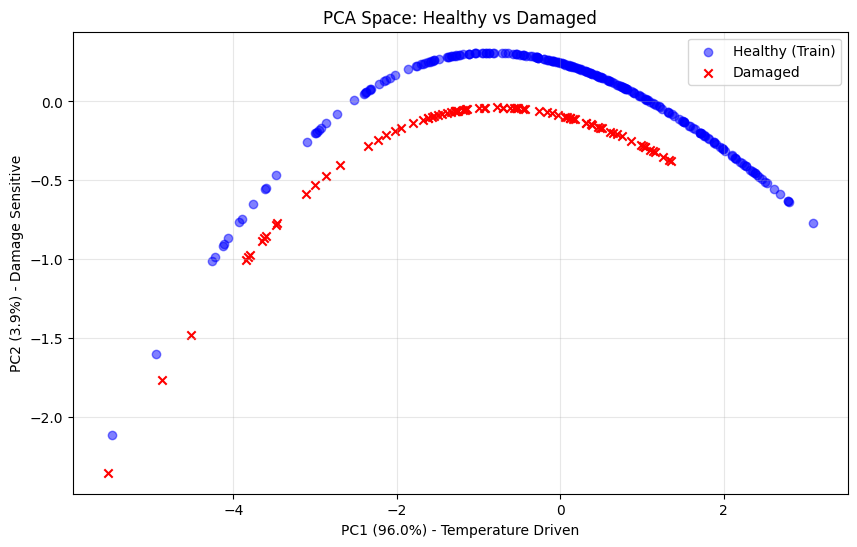

In [138]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Prepare Data
# We use all 3 modes
X = measured_frequencies 

# Split into Train (Healthy) and Test (All)
X_train = X[train_mask]

# 2. Standardize
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_all_std = scaler.transform(X)

# 3. Apply PCA
pca = PCA(n_components=3)
pca.fit(X_train_std)

# Project data
X_pca = pca.transform(X_all_std)

# 4. Visualize
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of the variance (Temperature Effect).")

plt.figure(figsize=(10, 6))
# Plot Healthy (Training)
plt.scatter(X_pca[train_mask, 0], X_pca[train_mask, 1], c='blue', alpha=0.5, label='Healthy (Train)')
# Plot Damaged (Test)
# We plot the points after damage_start_time
damage_mask = time >= damage_start_time
plt.scatter(X_pca[damage_mask, 0], X_pca[damage_mask, 1], c='red', marker='x', label='Damaged')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%) - Temperature Driven')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%) - Damage Sensitive')
plt.title('PCA Space: Healthy vs Damaged')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Automated Alarm System (Mahalanobis Distance)

To automate the detection, we calculate a single **Damage Index (DI)** for each measurement.
We use the **Mahalanobis Distance** in the residual subspace (PC2, PC3). This measures how far a point is from the "normal" distribution, considering the variance in each direction.

$$ DI = \sqrt{(x - \mu)^T \Sigma^{-1} (x - \mu)} $$

Where we only use the residual components (PC2, PC3).

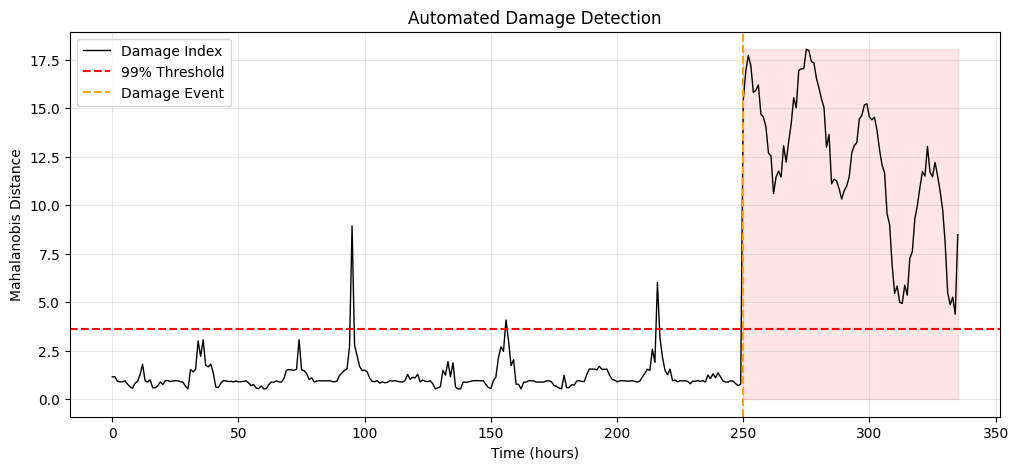

In [135]:
# We use PC2 and PC3 for damage detection (ignoring PC1 which is temperature)
# Extract residual components
residuals_pca = X_pca[:, 1:] # Columns 1 and 2 (PC2, PC3)

# Calculate statistics on Healthy Data
healthy_residuals = residuals_pca[train_mask]
mean_res = np.mean(healthy_residuals, axis=0)
cov_res = np.cov(healthy_residuals.T)
inv_cov_res = np.linalg.inv(cov_res)

def calculate_mahalanobis(data):
    # data shape (n_samples, n_components)
    diff = data - mean_res
    # MD = sqrt(diff * inv_cov * diff.T)
    # We use diag to get the diagonal elements of the result matrix (distance for each sample)
    md = np.sqrt(np.diag(diff @ inv_cov_res @ diff.T))
    return md

# Calculate DI for all data
damage_index = calculate_mahalanobis(residuals_pca)

# Define Threshold (e.g., 99% confidence interval of healthy data)
threshold_di = np.percentile(damage_index[train_mask], 99)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(time, damage_index, label='Damage Index', color='black', lw=1)
plt.axhline(y=threshold_di, color='red', linestyle='--', label='99% Threshold')
plt.axvline(x=damage_start_time, color='orange', linestyle='--', label='Damage Event')

# Highlight damage region
plt.fill_between(time, 0, max(damage_index), where=time>=damage_start_time, color='red', alpha=0.1)

plt.xlabel("Time (hours)")
plt.ylabel("Mahalanobis Distance")
plt.title("Automated Damage Detection")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Reality Check: Measurement Uncertainty (OMA)

In reality, we never measure the exact resonance frequencies directly. We estimate them from vibration data using **Operational Modal Analysis (OMA)** techniques (e.g., Peak Picking, FDD, SSI).

These estimation methods introduce uncertainty and noise. To make our simulation more realistic, we will add random noise to our "measured" frequencies before testing our damage detection algorithms.